# Car Price prediction project

<p align="left">
  <img src="https://amcdn.blob.core.windows.net/media/1/root/car-price-tag.jpg" width="450">
</p>


## Dataset

Cars dataset with features including make, model, year, engine, and other properties of the car used to predict its price.

## EDA 

We will examine a dataset in order to study:

- the distribution of the target variable;
- the features in this dataset;
- the distribution of values across these features;
- the data quality;
- the number of missing values.


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


In [35]:
df = pd.read_csv('data.csv')
display(df.head())
print(f"{len(df)} rows in dataset")


,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


11914 rows in dataset


As we can see, this dataset contains several columns:

- **make** — car brand (BMW, Toyota, etc.);
- **model** — car model;
- **year** — year of manufacture;
- **engine_fuel_type** — type of fuel required by the engine (diesel, electric, etc.);
- **engine_hp** — engine power in horsepower;
- **engine_cylinders** — number of cylinders in the engine;
- **transmission_type** — type of transmission (automatic or manual);
- **driven_wheels** — drivetrain (front-wheel, rear-wheel, all-wheel);
- **number_of_doors** — number of doors in the car;
- **market_category** — market segment (premium, crossover, etc.);
- **vehicle_size** — vehicle size (compact, midsize, or large);
- **vehicle_style** — body style (sedan, convertible, etc.);
- **highway_mpg** — miles per gallon (mpg) on the highway;
- **city_mpg** — miles per gallon (mpg) in the city;
- **popularity** — number of mentions of the vehicle on Twitter;
- **msrp** — manufacturer’s suggested retail price.


For us, the most interesting column here is the last one: **MSRP** (the manufacturer’s suggested retail price, or simply the price).  
We will use it to predict car prices.


The **MSRP** column contains important information — it is our target variable **y**, which represents the value we aim to learn how to predict.  
One of the first steps in exploratory data analysis should always be to understand what the values of **y** represent.


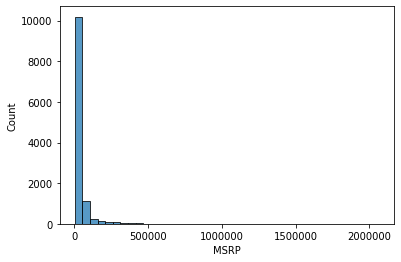

In [36]:
sns.histplot(df.MSRP, bins=40)

plt.ticklabel_format(style='plain', axis='x')
plt.show()


Having plotted this graph, we immediately note that the price distribution has a very long "tail." On the left side, there are many cars with low prices, but their number quickly decreases, leaving a long "tail" of very few cars with high prices.  
  
We can see it from boxplot below that there are few cars that are extremely expensive.

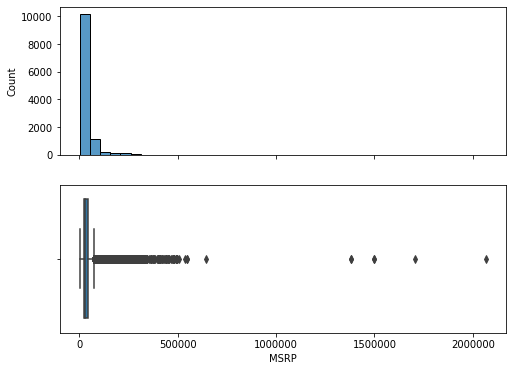

In [37]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

sns.histplot(df.MSRP, bins=40, ax=axes[0])
axes[0].set_ylabel("Count")

sns.boxplot(x=df.MSRP, ax=axes[1])
axes[1].set_xlabel("MSRP")
plt.ticklabel_format(style='plain', axis='x')
plt.show()


We can look at the details by zooming in a bit and selecting values ​​below $100,000.

<AxesSubplot: xlabel='MSRP', ylabel='Count'>

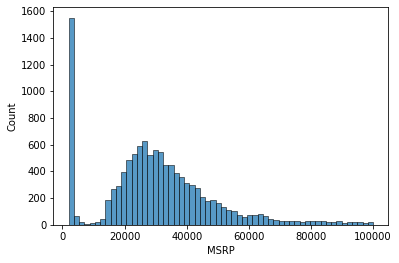

In [38]:
sns.histplot(df.MSRP[df.MSRP < 100000])

Due to the long tail, it is quite difficult to clearly observe the distribution.  
Moreover, this long tail has an even greater impact on the model: such a distribution can significantly confuse the model, leading to suboptimal training performance.

One way to address this issue is to apply a logarithmic transformation.  
By applying the `log` function to the prices, we remove this undesirable effect.

$$
y_{\text{new}} = \log(y + 1)
$$


<AxesSubplot: xlabel='MSRP', ylabel='Count'>

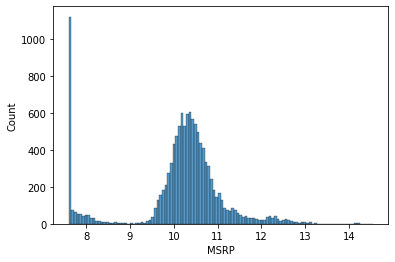

In [39]:
log_price = np.log1p(df.MSRP)
sns.histplot(log_price)

### Checking for NULL or Missing values

We will examine other features more closely a bit later, but there is something we must do now — check the data for missing values. This step is important because machine learning models, as a rule, cannot automatically handle missing values. We need to find out if we will need to do anything special to process them

In [40]:
df.isnull().sum()

Make                    0
Model                   0
Year                    0
Engine Fuel Type        3
Engine HP              69
Engine Cylinders       30
Transmission Type       0
Driven_Wheels           0
Number of Doors         6
Market Category      3742
Vehicle Size            0
Vehicle Style           0
highway MPG             0
city mpg                0
Popularity              0
MSRP                    0
dtype: int64

- **No missing values** found in `MSRP` (our target variable).
- This is a positive outcome, since missing target values would make records unusable for training.
- Several columns contain missing values.
- The most notable case is `market_category`, which has **almost 4,000 rows** with missing entries.



```markdown
Full dataset
     |
     +------------------+------------------+
     |                  |                  |
Training set     Validation set        Test set
     |                  |                  |
Training          Validation              Test


We will split dataset into three frames in our model:  
- **Validation** — 20 %
- **Testing** — 20 %
- **Training** — 60 %

In [41]:
n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val-n_test)

np.random.seed(2)
idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

In [ ]:
y_train = np.log1p(df_train.MSRP.values)
y_val = np.log1p(df_val.MSRP.values)
y_test = np.log1p(df_test.MSRP.values)